## 1. The Recommendation Problem
Recommenders have been around since at least 1992. Today we see different flavours of recommenders, deployed across different verticals: 

- Amazon
- Netflix
- Facebook
- Last.fm.

What exactly do they do?

### Definitions from the literature

- *In a typical recommender system people provide recommendations as inputs, which
the system then aggregates and directs to appropriate recipients.* -- Resnick
and Varian, 1997

- *Collaborative filtering simply means that people collaborate to help one
another perform filtering by recording their reactions to documents they read.*
-- Goldberg et al, 1992

- *In its most common formulation, the recommendation problem is reduced to the
problem of estimating ratings for the items that have not been seen by a
user. Intuitively, this estimation is usually based on the ratings given by this
user to other items and on some other information [...] Once we can estimate
ratings for the yet unrated items, we can recommend to the user the item(s) with
the highest estimated rating(s).* -- Adomavicius and Tuzhilin, 2005

- *Driven by computer algorithms, recommenders help consumers
by selecting products they will probably like and might buy
based on their browsing, searches, purchases, and preferences.* -- Konstan and Riedl, 2012

### Notation

- $U$ is the set of users in our domain. Its size is $|U|$.
- $I$ is the set of items in our domain. Its size is $|I|$.
- $I(u)$ is the set of items that user $u$ has rated.
- $-I(u)$ is the complement of $I(u)$ i.e., the set of items not yet seen by user $u$.
- $U(i)$ is the set of users that have rated item $i$.
- $-U(i)$ is the complement of $U(i)$.
- $S(u,i)$ is a function that measures the utility of item $i$ for user $u$.

### Goal of a recommendation system

$
i^{*} = argmax_{i \in -I(u)} S(u,i), \forall{u \in U}
$ - find the most useful item i* for user u.

### Problem statement

The recommendation problem in its most basic form is quite simple to define:

```
|-------------------+-----+-----+-----+-----+-----|
| user_id, movie_id | m_1 | m_2 | m_3 | m_4 | m_5 |
|-------------------+-----+-----+-----+-----+-----|
| u_1               | ?   | ?   | 4   | ?   | 1   |
|-------------------+-----+-----+-----+-----+-----|
| u_2               | 3   | ?   | ?   | 2   | 2   |
|-------------------+-----+-----+-----+-----+-----|
| u_3               | 3   | ?   | ?   | ?   | ?   |
|-------------------+-----+-----+-----+-----+-----|
| u_4               | ?   | 1   | 2   | 1   | 1   |
|-------------------+-----+-----+-----+-----+-----|
| u_5               | ?   | ?   | ?   | ?   | ?   |
|-------------------+-----+-----+-----+-----+-----|
| u_6               | 2   | ?   | 2   | ?   | ?   |
|-------------------+-----+-----+-----+-----+-----|
| u_7               | ?   | ?   | ?   | ?   | ?   |
|-------------------+-----+-----+-----+-----+-----|
| u_8               | 3   | 1   | 5   | ?   | ?   |
|-------------------+-----+-----+-----+-----+-----|
| u_9               | ?   | ?   | ?   | ?   | 2   |
|-------------------+-----+-----+-----+-----+-----|
```

*Given a partially filled matrix of ratings ($|U|x|I|$), estimate the missing values.*


In [1]:
import os
os.chdir('C:/Sereda/Lectures/Springboard/22.Hot_Topics_in_ML/22.3.Recommendation_Systems/pycon2015_tutorial322')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 2. The MovieLens dataset: loading and first look

The MovieLens dataset files contain 1,000,209 anonymous ratings of approximately 3,883 movies made by 6,040 MovieLens users who joined MovieLens in 2000.

The MovieLens data is spread across three files. We'll load each file using the `pd.read_table` function:

In [2]:
users = pd.read_table('data/ml-1m/users.dat',
                      sep='::', header=None, 
                      names=['user_id', 'gender', 'age', 'occupation', 'zip'])

ratings = pd.read_table('data/ml-1m/ratings.dat',
                        sep='::', header=None, 
                        names=['user_id', 'movie_id', 'rating', 'timestamp'])

movies = pd.read_table('data/ml-1m/movies.dat',
                       sep='::', header=None, 
                       names=['movie_id', 'title', 'genres'],
                       encoding='latin-1')

# show how one of them looks
ratings.head(5)


C:\Users\Admin\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


Using `pd.merge` we get it all into  one big DataFrame.

In [3]:
movielens = pd.merge(pd.merge(ratings, users), movies)
movielens.head()

,user_id,movie_id,rating,timestamp,gender,age,occupation,zip,title,genres
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,M,56,16,70072,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,M,25,12,32793,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,M,25,7,22903,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,M,50,1,95350,One Flew Over the Cuckoo's Nest (1975),Drama


In [4]:
movielens.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   user_id     1000209 non-null  int64 
 1   movie_id    1000209 non-null  int64 
 2   rating      1000209 non-null  int64 
 3   timestamp   1000209 non-null  int64 
 4   gender      1000209 non-null  object
 5   age         1000209 non-null  int64 
 6   occupation  1000209 non-null  int64 
 7   zip         1000209 non-null  object
 8   title       1000209 non-null  object
 9   genres      1000209 non-null  object
dtypes: int64(6), object(4)
memory usage: 83.9+ MB


In [5]:
print("No. of users =", movielens.user_id.nunique())
print("No. of movies =", movielens.movie_id.nunique())
print("No. of ratings =", len(movielens))

No. of users = 6040
No. of movies = 3706
No. of ratings = 1000209


## 3. Evaluation of models
Before we start building our minimal reco engine we need a basic mechanism to evaluate the performance of our engine. For that we will:

- split the data into train and test sets
- introduce a performance criterion
- write an `evaluate` function.

### 3.1 Train-test split of ratings
Here we generate training and testing sets for evaluation.
- take a smaller sample from the full 1M dataset for speed reasons;
- make sure that we have at least 2 ratings per user in that subset;
- split the result into training and testing sets.

In [6]:
def train_test_split(df, test_proportion):
    sampled_ids = np.random.choice(df.index,
                                   size=np.int64(np.ceil(df.index.size * test_proportion)),
                                   replace=False)
    df_test = df.loc[sampled_ids]
    df_train = df.loc[set(df.index) - set(sampled_ids)]
    return df_train, df_test

In [99]:
movielens_train, movielens_test = train_test_split(movielens, 0.2)
print(movielens_train.shape)
print(movielens_test.shape)

(800167, 10)
(200042, 10)


Store these two sets in CSV files:

In [10]:
movielens_train.to_csv('data/movielens_train.csv')
movielens_test.to_csv('data/movielens_test.csv')

Load the training and testing subsets

In [7]:
# Load the training and testing subsets
movielens_train = pd.read_csv('data/movielens_train.csv', index_col=0)
movielens_test = pd.read_csv('data/movielens_test.csv', index_col=0)
movielens_train.head()

,user_id,movie_id,rating,timestamp,gender,age,occupation,zip,title,genres
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,M,25,12,32793,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,M,50,1,95350,One Flew Over the Cuckoo's Nest (1975),Drama
5,18,1193,4,978156168,F,18,3,95825,One Flew Over the Cuckoo's Nest (1975),Drama
6,19,1193,5,982730936,M,1,10,48073,One Flew Over the Cuckoo's Nest (1975),Drama


In [103]:
movielens_train.genres.max()

20

In [8]:
print("Min rating =", movielens_test.rating.min())
print("Max rating =", movielens_test.rating.max())

Min rating = 1
Max rating = 5


### 3.2 Performance criterion

Performance evaluation of recommendation systems is an entire topic all in
itself. Some of the options include:

- RMSE: $\sqrt{\frac{\sum(\hat y - y)^2}{n}}$
- Precision / Recall / F-scores
- ROC curves
- Cost curves

Here we use RMSE only.

In [9]:
def rmse(y_pred, y_true):
    """ Compute Root Mean Squared Error. """
    
    return np.sqrt(np.mean(np.power(y_pred - y_true, 2)))

### Evaluation: the 'evaluate' method

In [10]:
def evaluate(estimate_f):
    """ RMSE-based predictive performance evaluation with pandas. """
    
    ids_to_estimate = zip(movielens_test.user_id, movielens_test.movie_id)
    estimated = np.array([estimate_f(u,i) for (u,i) in ids_to_estimate])
    real = movielens_test.rating.values
    return rmse(estimated, real)

In [21]:
# Dummy recommender
def dummy_recommender_function(user_id, movie_id):
    return 4

In [16]:
print('RMSE for my estimate function: %s' % evaluate(dummy_recommender_function))

RMSE for my estimate function: 1.1902216214736117


## 4. Well-known Solutions to the Recommendation Problem
### 4.1 Content-based filtering

*Recommend based on the user's rating history.* 

Generic expression (notice how this is kind of a 'row-based' approach):

$$ 
\newcommand{\aggr}{\mathop{\rm aggr}\nolimits}
r_{u,i} = \aggr_{i' \in I(u)} [r_{u,i'}]
$$


A simple example using the mean as an aggregation function:

$$ 
r_{u,i} = \bar r_u = \frac{\sum_{i' \in I(u)} r_{u,i'}}{|I(u)|} 
$$

### 4.1.1 Content-based filtering using mean ratings
With this table-like representation of the ratings data, a basic content-based
filter becomes a one-liner function.

In [74]:
def content_mean(user_id, movie_id):
    """ Simple content-filtering based on mean ratings. """
    
    user_condition = movielens_train.user_id == user_id
    return movielens_train.loc[user_condition, 'rating'].mean()

print('RMSE for estimate1: %s' % evaluate(content_mean))

RMSE for estimate1: 1.0358078857231683


### 4.1.2 Content-based filtering using median ratings

In [82]:
def content_median(user_id, movie_id):
    """ Simple content-filtering based on median ratings. """
    
    user_condition = movielens_train.user_id == user_id
    return movielens_train.loc[user_condition, 'rating'].median()

print('RMSE for estimate1: %s' % evaluate(content_median))

RMSE for estimate1: 1.088656793273783


### 4.1.2 Generalizations of the aggregation function for content-based filtering: incorporating similarities
Here are some basic ways in which we can generalize the simple mean-based algorithms we discussed before. Possibly incorporating metadata about items, which makes the term 'content' make more sense now.

$$ r_{u,i} = k \sum_{i' \in I(u)} sim(i, i') \; r_{u,i'} $$

$$ r_{u,i} = \bar r_u + k \sum_{i' \in I(u)} sim(i, i') \; (r_{u,i'} - \bar r_u) $$

Here $k$ is a normalizing factor,

$$ k = \frac{1}{\sum_{i' \in I(u)} |sim(i,i')|} $$

and $\bar r_u$ is the average rating of user u:

$$ \bar r_u = \frac{\sum_{i \in I(u)} r_{u,i}}{|I(u)|} $$


### 4.2 Collaborative filtering

*Recommend based on other user's rating histories.* 

Generic expression (notice how this is kind of a 'col-based' approach):

$$ 
\newcommand{\aggr}{\mathop{\rm aggr}\nolimits}
r_{u,i} = \aggr_{u' \in U(i)} [r_{u',i}] 
$$

### 4.2.1 Collaborative filtering using mean ratings
A simple example using the mean as an aggregation function:
$$ 
r_{u,i} = \bar r_i = \frac{\sum_{u' \in U(i)} r_{u',i}}{|U(i)|} 
$$

In [78]:
def collab_mean(user_id, movie_id):
    """ Simple collaborative filtering based on mean ratings. """
    
    user_condition = movielens_train.user_id != user_id
    movie_condition = movielens_train.movie_id == movie_id
    ratings_by_others = movielens_train.loc[user_condition & movie_condition]
    if ratings_by_others.empty: 
        return 4.0
    return ratings_by_others['rating'].mean()

print('RMSE: %s' % evaluate(collab_mean))

RMSE: 0.9799205786940289


### 4.2.2 Collaborative filtering using median ratings

In [83]:
def collab_median(user_id, movie_id):
    """ Simple collaborative filtering based on median ratings. """
    
    user_condition = movielens_train.user_id != user_id
    movie_condition = movielens_train.movie_id == movie_id
    ratings_by_others = movielens_train.loc[user_condition & movie_condition]
    if ratings_by_others.empty: 
        return 4.0
    return ratings_by_others['rating'].median()

print('RMSE: %s' % evaluate(collab_median))

RMSE: 1.0286959097771768


### 4.2.3 Generalizations of the aggregation function for collaborative filtering: incorporating similarities

Possibly incorporating metadata about users.

$$ r_{u,i} = k \sum_{u' \in U(i)} sim(u, u') \; r_{u',i} $$

$$ r_{u,i} = \bar r_u + k \sum_{u' \in U(i)} sim(u, u') \; (r_{u',i} - \bar r_u) $$

Here $k$ is a normalizing factor,

$$ k = \frac{1}{\sum_{u' \in U(i)} |sim(u,u')|} $$

and $\bar r_u$ is the average rating of user u:

$$ \bar r_u = \frac{\sum_{i \in I(u)} r_{u,i}}{|I(u)|} $$

We're going to need a user index from the users portion of the dataset. This will allow us to retrieve information given a specific user_id in a more convenient way:

In [13]:
user_info = users.set_index('user_id')
user_info.head(5)

,gender,age,occupation,zip
user_id,,,,
1,F,1,10,48067
2,M,56,16,70072
3,M,25,15,55117
4,M,45,7,02460
5,M,25,20,55455


With this in hand, we can now ask what the gender of a particular user_id is like so:

In [23]:
user_id = 3
user_info.loc[user_id, 'gender']

'M'

### Collaborative-based filtering using implicit similarity functions
Using the pandas aggregation framework we will build a collaborative filter that estimates ratings using an implicit `sim(u,u')` function to compare different users.

In [ ]:
def collab_gender(user_id, movie_id):
    """ Collaborative filtering using an implicit sim(u,u') based on gender. """
    
    user_condition = movielens_train.user_id != user_id
    movie_condition = movielens_train.movie_id == movie_id
    ratings_by_others = movielens_train.loc[user_condition & movie_condition]
    if ratings_by_others.empty: 
        return 3.0
    
    means_by_gender = ratings_by_others.pivot_table('rating', index='movie_id', columns='gender')
    user_gender = user_info.loc[user_id, 'gender']
    if user_gender in means_by_gender.columns: 
        return means_by_gender.loc[movie_id, user_gender]
    else:
        return means_by_gender.loc[movie_id].mean()

print('RMSE for collab_gender: %s' % evaluate(collab_gender))

### Collaborative-based filtering using custom similarity functions

In [28]:
def pearsonr(x, y):
  # Assume len(x) == len(y)
  n = len(x)
  sum_x = float(sum(x))
  sum_y = float(sum(y))
  sum_x_sq = sum(xi*xi for xi in x)
  sum_y_sq = sum(yi*yi for yi in y)
  psum = sum(xi*yi for xi, yi in zip(x, y))
  num = psum - (sum_x * sum_y/n)
  den = pow((sum_x_sq - pow(sum_x, 2) / n) * (sum_y_sq - pow(sum_y, 2) / n), 0.5)
  if den == 0: return 0
  return num / den

In [ ]:
def collab_Pearson(user_id, movie_id):
    """ Collaborative filtering using a custom Pearson r sim(u,u'). """
    # Prepare datastructures for estimation.
    all_user_profiles = movielens.pivot_table('rating', index='movie_id', columns='user_id')
    # Ratings weighted by correlation similarity.
    user_condition = movielens_train.user_id != user_id
    movie_condition = movielens_train.movie_id == movie_id
    ratings_by_others = movielens_train.loc[user_condition & movie_condition]
    if ratings_by_others.empty:
        return 4.0
    ratings_by_others.set_index('user_id', inplace=True)
    their_ids = ratings_by_others.index
    their_ratings = ratings_by_others.rating
    their_profiles = all_user_profiles[their_ids]
    user_profile = all_user_profiles[user_id]
    sims = their_profiles.apply(lambda profile: pearsonr(profile, user_profile), axis=0)
    ratings_sims = pd.DataFrame({'sim': sims, 'rating': their_ratings})
    ratings_sims = ratings_sims[ratings_sims.sim > 0]
    if ratings_sims.empty:
        return their_ratings.mean()
    else:
        return np.average(ratings_sims.rating, weights=ratings_sims.sim)
    
print('RMSE for CollabPearsonReco: %s' % evaluate(collab_Pearson))

### A few similarity functions

These were all written to operate on two pandas Series, each one representing the rating history of two different users. You can also apply them to any two feature vectors that describe users or items. In all cases, the higher the return value, the more similar two Series are. You might need to add checks for edge cases, such as divisions by zero, etc.

- Euclidean 'similarity'

$$ sim(x,y) = \frac{1}{1 + \sqrt{\sum (x - y)^2}}$$

In [ ]:
def sim_euclidean(s1, s2):
    """Take two pd.Series objects and return their euclidean 'similarity'."""
    diff = s1 - s2
    return 1 / (1 + np.sqrt(np.sum(diff ** 2)))

In [ ]:
def collab_Euclidean(user_id, movie_id):
    """ Collaborative filtering using a custom Euclidean sim(u,u'). """
    # Prepare datastructures for estimation.
    all_user_profiles = movielens.pivot_table('rating', index='movie_id', columns='user_id')
    # Ratings weighted by Euclidean similarity.
    user_condition = movielens_train.user_id != user_id
    movie_condition = movielens_train.movie_id == movie_id
    ratings_by_others = movielens_train.loc[user_condition & movie_condition]
    if ratings_by_others.empty:
        return 4.0
    ratings_by_others.set_index('user_id', inplace=True)
    their_ids = ratings_by_others.index
    their_ratings = ratings_by_others.rating
    their_profiles = all_user_profiles[their_ids]
    user_profile = all_user_profiles[user_id]
    sims = their_profiles.apply(lambda profile: sim_euclidean(profile, user_profile), axis=0)
    ratings_sims = pd.DataFrame({'sim': sims, 'rating': their_ratings})
    ratings_sims = ratings_sims[ratings_sims.sim > 0]
    if ratings_sims.empty:
        return their_ratings.mean()
    else:
        return np.average(ratings_sims.rating, weights=ratings_sims.sim)
    
print('RMSE for collab_Euclidean: %s' % evaluate(collab_Euclidean))

- Cosine similarity

$$ sim(x,y) = \frac{(x . y)}{\sqrt{(x . x) (y . y)}} $$

In [ ]:
def sim_cosine(s1, s2):
    """Take two pd.Series objects and return their cosine similarity."""
    return np.sum(s1 * s2) / np.sqrt(np.sum(s1 ** 2) * np.sum(s2 ** 2))

In [ ]:
def collab_cosine(user_id, movie_id):
    """ Collaborative filtering using a custom cosine sim(u,u'). """
    # Prepare datastructures for estimation.
    all_user_profiles = movielens.pivot_table('rating', index='movie_id', columns='user_id')
    # Ratings weighted by Euclidean similarity.
    user_condition = movielens_train.user_id != user_id
    movie_condition = movielens_train.movie_id == movie_id
    ratings_by_others = movielens_train.loc[user_condition & movie_condition]
    if ratings_by_others.empty:
        return 4.0
    ratings_by_others.set_index('user_id', inplace=True)
    their_ids = ratings_by_others.index
    their_ratings = ratings_by_others.rating
    their_profiles = all_user_profiles[their_ids]
    user_profile = all_user_profiles[user_id]
    sims = their_profiles.apply(lambda profile: sim_cosine(profile, user_profile), axis=0)
    ratings_sims = pd.DataFrame({'sim': sims, 'rating': their_ratings})
    ratings_sims = ratings_sims[ratings_sims.sim > 0]
    if ratings_sims.empty:
        return their_ratings.mean()
    else:
        return np.average(ratings_sims.rating, weights=ratings_sims.sim)
    
print('RMSE for collab_cosine: %s' % evaluate(collab_cosine))

- Jaccard similarity

$$ sim(x,y) = \frac{(x . y)}{(x . x) + (y . y) - (x . y)} $$

In [187]:
def sim_jaccard(s1, s2):
    dotp = np.sum(s1 * s2)
    return dotp / (np.sum(s1 ** 2) + np.sum(s2 ** 2) - dotp)

def sim_binjaccard(s1, s2):
    dotp = (s1.index & s2.index).size
    return dotp / (s1.sum() + s2.sum() - dotp)

In [ ]:
def collab_jaccard(user_id, movie_id):
    """ Collaborative filtering using a custom cosine sim(u,u'). """
    # Prepare datastructures for estimation.
    all_user_profiles = movielens.pivot_table('rating', index='movie_id', columns='user_id')
    # Ratings weighted by Euclidean similarity.
    user_condition = movielens_train.user_id != user_id
    movie_condition = movielens_train.movie_id == movie_id
    ratings_by_others = movielens_train.loc[user_condition & movie_condition]
    if ratings_by_others.empty:
        return 4.0
    ratings_by_others.set_index('user_id', inplace=True)
    their_ids = ratings_by_others.index
    their_ratings = ratings_by_others.rating
    their_profiles = all_user_profiles[their_ids]
    user_profile = all_user_profiles[user_id]
    sims = their_profiles.apply(lambda profile: sim_jaccard(profile, user_profile), axis=0)
    ratings_sims = pd.DataFrame({'sim': sims, 'rating': their_ratings})
    ratings_sims = ratings_sims[ratings_sims.sim > 0]
    if ratings_sims.empty:
        return their_ratings.mean()
    else:
        return np.average(ratings_sims.rating, weights=ratings_sims.sim)
    
print('RMSE for collab_cosine: %s' % evaluate(collab_jaccard))

In [188]:
def collab_binjaccard(user_id, movie_id):
    """ Collaborative filtering using a custom cosine sim(u,u'). """
    # Prepare datastructures for estimation.
    all_user_profiles = movielens.pivot_table('rating', index='movie_id', columns='user_id')
    # Ratings weighted by Euclidean similarity.
    user_condition = movielens_train.user_id != user_id
    movie_condition = movielens_train.movie_id == movie_id
    ratings_by_others = movielens_train.loc[user_condition & movie_condition]
    if ratings_by_others.empty:
        return 4.0
    ratings_by_others.set_index('user_id', inplace=True)
    their_ids = ratings_by_others.index
    their_ratings = ratings_by_others.rating
    their_profiles = all_user_profiles[their_ids]
    user_profile = all_user_profiles[user_id]
    sims = their_profiles.apply(lambda profile: sim_binjaccard(profile, user_profile), axis=0)
    ratings_sims = pd.DataFrame({'sim': sims, 'rating': their_ratings})
    ratings_sims = ratings_sims[ratings_sims.sim > 0]
    if ratings_sims.empty:
        return their_ratings.mean()
    else:
        return np.average(ratings_sims.rating, weights=ratings_sims.sim)
    
print('RMSE for collab_cosine: %s' % evaluate(collab_binjaccard))

C:\Users\Admin\AppData\Local\Temp/ipykernel_8912/984912650.py:6: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  dotp = (s1.index & s2.index).size
C:\Users\Admin\AppData\Local\Temp/ipykernel_8912/984912650.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  return dotp / (s1.sum() + s2.sum() - dotp)
C:\Users\Admin\anaconda3\lib\site-packages\numpy\lib\function_base.py:412: RuntimeWarning: invalid value encountered in double_scalars
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


KeyboardInterrupt: 

### Age similarity

In [15]:
age_min = movielens_train.age.min()
age_max = movielens_train.age.max()
print("Min age =",age_min)
print("Max age =",age_max)
age_amplitude = age_max - age_min
print("age_amplitude =",age_amplitude)

Min age = 1
Max age = 56
age_amplitude = 55


In [155]:
def sim_age(age1, age2):
    # linear function of age difference
    # age_amplitude = 55
    return 1 - abs(age1 - age2) / age_amplitude

In [159]:
def collab_age_sim(user_id, movie_id):
    """ Collaborative filtering using a custom age sim(u,u'). """
    # Ratings weighted by age similarity.
    user_condition = movielens_train.user_id != user_id
    movie_condition = movielens_train.movie_id == movie_id
    ratings_by_others = movielens_train.loc[user_condition & movie_condition]
    if ratings_by_others.empty:
        return 4.0
    ratings_by_others.set_index('user_id', inplace=True)
    their_ids = ratings_by_others.index
    their_ratings = ratings_by_others.rating
    their_ages = ratings_by_others['age']
    #user_age = movielens_train.loc[movielens_train['user_id'] == user_id, 'age']
    user_age = user_info.loc[user_id, 'age']
    sims = their_ages.apply(lambda age: sim_age(age, user_age)) #, axis=0
    ratings_sims = pd.DataFrame({'sim': sims, 'rating': their_ratings})
    ratings_sims = ratings_sims[ratings_sims.sim > 0]
    if ratings_sims.empty:
        return their_ratings.mean()
    else:
        return np.average(ratings_sims.rating, weights=ratings_sims.sim)
    
print('RMSE for collab_age_sim: %s' % evaluate(collab_age_sim))

RMSE for collab_age_sim: 0.9772907088995219


In [168]:
def sim_age2(age1, age2):
    # quadratic function of age difference
    # age_amplitude = 55
    c2 = -1/3025. # [-1/3025, 1/3025] How does '3025' depend on age_amplitude?
    x = np.abs(age1 - age2)
    return 1-(1/age_amplitude+age_amplitude*c2)*x+c2*x*x

In [ ]:
def collab_age2_sim(user_id, movie_id):
    """ Collaborative filtering using a custom age sim(u,u'). """
    # Ratings weighted by age similarity.
    user_condition = movielens_train.user_id != user_id
    movie_condition = movielens_train.movie_id == movie_id
    ratings_by_others = movielens_train.loc[user_condition & movie_condition]
    if ratings_by_others.empty:
        return 4.0
    ratings_by_others.set_index('user_id', inplace=True)
    their_ids = ratings_by_others.index
    their_ratings = ratings_by_others.rating
    their_ages = ratings_by_others['age']
    #user_age = movielens_train.loc[movielens_train['user_id'] == user_id, 'age']
    user_age = user_info.loc[user_id, 'age']
    sims = their_ages.apply(lambda age: sim_age2(age, user_age)) #, axis=0
    ratings_sims = pd.DataFrame({'sim': sims, 'rating': their_ratings})
    ratings_sims = ratings_sims[ratings_sims.sim > 0]
    if ratings_sims.empty:
        return their_ratings.mean()
    else:
        return np.average(ratings_sims.rating, weights=ratings_sims.sim)
    
print('RMSE for collab_age_sim: %s' % evaluate(collab_age2_sim))

In [99]:
def sim_age3(age1, age2):
    # quadratic function of age difference
    # age_amplitude = 55
    c2 = 1/3025. # [-1/3025, 1/3025] How does '3025' depend on age_amplitude?
    x = np.abs(age1 - age2)
    return 1-(1/age_amplitude+age_amplitude*c2)*x+c2*x*x

In [16]:
def collab_age3_sim(user_id, movie_id):
    """ Collaborative filtering using a custom age sim(u,u'). """
    # Ratings weighted by age similarity.
    user_condition = movielens_train.user_id != user_id
    movie_condition = movielens_train.movie_id == movie_id
    ratings_by_others = movielens_train.loc[user_condition & movie_condition]
    if ratings_by_others.empty:
        return 4.0
    ratings_by_others.set_index('user_id', inplace=True)
    their_ids = ratings_by_others.index
    their_ratings = ratings_by_others.rating
    their_ages = ratings_by_others['age']
    #user_age = movielens_train.loc[movielens_train['user_id'] == user_id, 'age']
    user_age = user_info.loc[user_id, 'age']
    sims = their_ages.apply(lambda age: sim_age3(age, user_age)) #, axis=0
    ratings_sims = pd.DataFrame({'sim': sims, 'rating': their_ratings})
    ratings_sims = ratings_sims[ratings_sims.sim > 0]
    if ratings_sims.empty:
        return their_ratings.mean()
    else:
        return np.average(ratings_sims.rating, weights=ratings_sims.sim)
    
print('RMSE for collab_age3_sim: %s' % evaluate(collab_age3_sim))

RMSE for collab_age_sim: 0.9774542378193612


In [190]:
def sim_age_p2(age1, age2):
    ''' Quadratic function of age difference: f(x) = 1 - (1/A + A*c2)*|x| + c2*x^2.
    Properties: f(0) = 1, f(A) = 0, f(-x) = f(x).'''
    # age_amplitude = 55
    c2 = -1/3025. # [-1/3025, 1/3025] How does '3025' depend on age_amplitude?
    x = np.abs(age1 - age2)
    return 1-(1/age_amplitude+age_amplitude*c2)*x+c2*x*x

In [ ]:
def collab_age_p2_sim(user_id, movie_id):
    """ Collaborative filtering using a custom age sim(u,u'). """
    # Ratings weighted by age similarity.
    user_condition = movielens_train.user_id != user_id
    movie_condition = movielens_train.movie_id == movie_id
    ratings_by_others = movielens_train.loc[user_condition & movie_condition]
    if ratings_by_others.empty:
        return 4.0
    ratings_by_others.set_index('user_id', inplace=True)
    their_ids = ratings_by_others.index
    their_ratings = ratings_by_others.rating
    their_ages = ratings_by_others['age']
    user_age = user_info.loc[user_id, 'age']
    sims = their_ages.apply(lambda age: sim_age_p2(age, user_age)) #, axis=0
    ratings_sims = pd.DataFrame({'sim': sims, 'rating': their_ratings})
    #ratings_sims = ratings_sims[ratings_sims.sim > 0]
    if ratings_sims.empty:
        return their_ratings.mean()
    else:
        return np.average(ratings_sims.rating, weights=ratings_sims.sim)
    
print('RMSE for collab_age_sim: %s' % evaluate(collab_age_p2_sim))

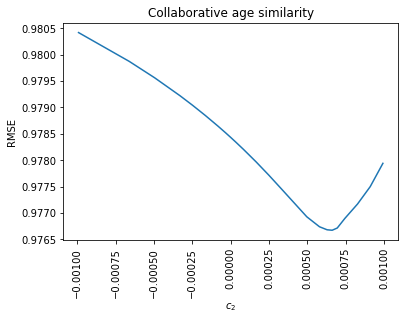

In [186]:
results_collab_age_c2p = {'c2':[-3/3025., -2/3025., -1.5/3025., -1/3025., -0.75/3025., -0.5/3025., -0.25/3025., -0.1/3025., 0, 0.1/3025., 0.25/3025., 0.5/3025., 0.75/3025., 1/3025., 1.5/3025., 1.75/3025., 1.9/3025., 2/3025., 2.1/3025., 2.25/3025., 2.5/3025., 2.75/3025., 3/3025.],
                         'RMSE':[0.9804165382325288, 0.9798702148432702, 0.9795600177752636, 0.9792200325937115, 0.9790373685841944, 0.9788453223484052, 0.9786431039345292, 0.9785165383978286, 0.9784298638900913, 0.97834128664308, 0.9782047381005846, 0.9779669793478626, 0.977716334301681, 0.9774542378193612, 0.9769261294723154, 0.9767375134591489, 0.9766801706304308, 0.9766716144985979, 0.9767138227767368, 0.9768957590161887, 0.9771686686197217, 0.9774980306449679, 0.9779394112377292]}
plt.plot(results_collab_age_c2p['c2'], results_collab_age_c2p['RMSE'])
plt.xticks(rotation = 90)
plt.ylabel('RMSE')
plt.xlabel('$c_2$')
plt.title('Collaborative age similarity');

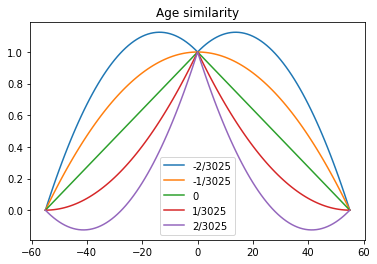

In [164]:
xs = np.arange(-age_amplitude,age_amplitude+1)
for c2 in [-2/3025.,-1/3025., 0, 1/3025., 2/3025.]:
    plt.plot(xs, 1-(1/age_amplitude+age_amplitude*c2)*np.abs(xs)+c2*xs*xs)
    plt.title(f'$c_{2}$={c2}')
plt.legend(['-2/3025', '-1/3025', '0', '1/3025', '2/3025'])
plt.title('Age similarity');
del c2

In [ ]:
def sim_age_p2(age1, age2):
    ''' Quadratic function of age difference: f(x) = 1 - (1/A + A*c2)*|x| + c2*x^2.
    Properties: f(0) = 1, f(A) = 0, f(-x) = f(x).'''
    # age_amplitude = 55
    c2 = -2/3025. # [-1/3025, 1/3025] How does '3025' depend on age_amplitude?
    x = np.abs(age1 - age2)
    return 1-(1/age_amplitude+age_amplitude*c2)*x+c2*x*x

In [ ]:
def collab_age_p2_sim(user_id, movie_id):
    """ Collaborative filtering using a custom age sim(u,u'). """
    # Ratings weighted by age similarity.
    user_condition = movielens_train.user_id != user_id
    movie_condition = movielens_train.movie_id == movie_id
    ratings_by_others = movielens_train.loc[user_condition & movie_condition]
    if ratings_by_others.empty:
        return 4.0
    ratings_by_others.set_index('user_id', inplace=True)
    their_ids = ratings_by_others.index
    their_ratings = ratings_by_others.rating
    their_ages = ratings_by_others['age']
    user_age = user_info.loc[user_id, 'age']
    sims = their_ages.apply(lambda age: sim_age_p2(age, user_age)) #, axis=0
    ratings_sims = pd.DataFrame({'sim': sims, 'rating': their_ratings})
    #ratings_sims = ratings_sims[ratings_sims.sim > 0]
    if ratings_sims.empty:
        return their_ratings.mean()
    else:
        return np.average(ratings_sims.rating, weights=ratings_sims.sim)
    
print('RMSE for collab_age_sim: %s' % evaluate(collab_age_p2_sim))

In [ ]:
def sim_age_p2(age1, age2):
    ''' Quadratic function of age difference: f(x) = 1 - (1/A + A*c2)*|x| + c2*x^2.
    Properties: f(0) = 1, f(A) = 0, f(-x) = f(x).'''
    # age_amplitude = 55
    c2 = -1.5/3025. # [-1/3025, 1/3025] How does '3025' depend on age_amplitude?
    x = np.abs(age1 - age2)
    return 1-(1/age_amplitude+age_amplitude*c2)*x+c2*x*x

In [ ]:
def collab_age_p2_sim(user_id, movie_id):
    """ Collaborative filtering using a custom age sim(u,u'). """
    # Ratings weighted by age similarity.
    user_condition = movielens_train.user_id != user_id
    movie_condition = movielens_train.movie_id == movie_id
    ratings_by_others = movielens_train.loc[user_condition & movie_condition]
    if ratings_by_others.empty:
        return 4.0
    ratings_by_others.set_index('user_id', inplace=True)
    their_ids = ratings_by_others.index
    their_ratings = ratings_by_others.rating
    their_ages = ratings_by_others['age']
    user_age = user_info.loc[user_id, 'age']
    sims = their_ages.apply(lambda age: sim_age_p2(age, user_age)) #, axis=0
    ratings_sims = pd.DataFrame({'sim': sims, 'rating': their_ratings})
    #ratings_sims = ratings_sims[ratings_sims.sim > 0]
    if ratings_sims.empty:
        return their_ratings.mean()
    else:
        return np.average(ratings_sims.rating, weights=ratings_sims.sim)
    
print('RMSE for collab_age_sim: %s' % evaluate(collab_age_p2_sim))

In [ ]:
def sim_age_p2(age1, age2):
    ''' Quadratic function of age difference: f(x) = 1 - (1/A + A*c2)*|x| + c2*x^2.
    Properties: f(0) = 1, f(A) = 0, f(-x) = f(x).'''
    # age_amplitude = 55
    c2 = -0.5/3025. # [-1/3025, 1/3025] How does '3025' depend on age_amplitude?
    x = np.abs(age1 - age2)
    return 1-(1/age_amplitude+age_amplitude*c2)*x+c2*x*x

In [ ]:
def collab_age_p2_sim(user_id, movie_id):
    """ Collaborative filtering using a custom age sim(u,u'). """
    # Ratings weighted by age similarity.
    user_condition = movielens_train.user_id != user_id
    movie_condition = movielens_train.movie_id == movie_id
    ratings_by_others = movielens_train.loc[user_condition & movie_condition]
    if ratings_by_others.empty:
        return 4.0
    ratings_by_others.set_index('user_id', inplace=True)
    their_ids = ratings_by_others.index
    their_ratings = ratings_by_others.rating
    their_ages = ratings_by_others['age']
    user_age = user_info.loc[user_id, 'age']
    sims = their_ages.apply(lambda age: sim_age_p2(age, user_age)) #, axis=0
    ratings_sims = pd.DataFrame({'sim': sims, 'rating': their_ratings})
    #ratings_sims = ratings_sims[ratings_sims.sim > 0]
    if ratings_sims.empty:
        return their_ratings.mean()
    else:
        return np.average(ratings_sims.rating, weights=ratings_sims.sim)
    
print('RMSE for collab_age_sim: %s' % evaluate(collab_age_p2_sim))

In [ ]:
0.9784298638900913-0.9784298638900913

In [ ]:
def sim_age_p2(age1, age2):
    ''' Quadratic function of age difference: f(x) = 1 - (1/A + A*c2)*|x| + c2*x^2.
    Properties: f(0) = 1, f(A) = 0, f(-x) = f(x).'''
    # age_amplitude = 55
    c2 = 2.75/3025. # [-1/3025, 1/3025] How does '3025' depend on age_amplitude?
    x = np.abs(age1 - age2)
    return 1-(1/age_amplitude+age_amplitude*c2)*x+c2*x*x

In [ ]:
def collab_age_p2_sim(user_id, movie_id):
    """ Collaborative filtering using a custom age sim(u,u'). """
    # Ratings weighted by age similarity.
    user_condition = movielens_train.user_id != user_id
    movie_condition = movielens_train.movie_id == movie_id
    ratings_by_others = movielens_train.loc[user_condition & movie_condition]
    if ratings_by_others.empty:
        return 4.0
    ratings_by_others.set_index('user_id', inplace=True)
    their_ids = ratings_by_others.index
    their_ratings = ratings_by_others.rating
    their_ages = ratings_by_others['age']
    user_age = user_info.loc[user_id, 'age']
    sims = their_ages.apply(lambda age: sim_age_p2(age, user_age)) #, axis=0
    ratings_sims = pd.DataFrame({'sim': sims, 'rating': their_ratings})
    #ratings_sims = ratings_sims[ratings_sims.sim > 0]
    if ratings_sims.empty:
        return their_ratings.mean()
    else:
        return np.average(ratings_sims.rating, weights=ratings_sims.sim)
    
print('RMSE for collab_age_sim: %s' % evaluate(collab_age_p2_sim))

In [ ]:
def sim_age_p2(age1, age2):
    ''' Quadratic function of age difference: f(x) = 1 - (1/A + A*c2)*|x| + c2*x^2.
    Properties: f(0) = 1, f(A) = 0, f(-x) = f(x).'''
    # age_amplitude = 55
    c2 = 1.75/3025. # [-1/3025, 1/3025] How does '3025' depend on age_amplitude?
    x = np.abs(age1 - age2)
    return 1-(1/age_amplitude+age_amplitude*c2)*x+c2*x*x

In [ ]:
def collab_age_p2_sim(user_id, movie_id):
    """ Collaborative filtering using a custom age sim(u,u'). """
    # Ratings weighted by age similarity.
    user_condition = movielens_train.user_id != user_id
    movie_condition = movielens_train.movie_id == movie_id
    ratings_by_others = movielens_train.loc[user_condition & movie_condition]
    if ratings_by_others.empty:
        return 4.0
    ratings_by_others.set_index('user_id', inplace=True)
    their_ids = ratings_by_others.index
    their_ratings = ratings_by_others.rating
    their_ages = ratings_by_others['age']
    user_age = user_info.loc[user_id, 'age']
    sims = their_ages.apply(lambda age: sim_age_p2(age, user_age)) #, axis=0
    ratings_sims = pd.DataFrame({'sim': sims, 'rating': their_ratings})
    #ratings_sims = ratings_sims[ratings_sims.sim > 0]
    if ratings_sims.empty:
        return their_ratings.mean()
    else:
        return np.average(ratings_sims.rating, weights=ratings_sims.sim)
    
print('RMSE for collab_age_sim: %s' % evaluate(collab_age_p2_sim))

In [ ]:
def sim_age_p2(age1, age2):
    ''' Quadratic function of age difference: f(x) = 1 - (1/A + A*c2)*|x| + c2*x^2.
    Properties: f(0) = 1, f(A) = 0, f(-x) = f(x).'''
    # age_amplitude = 55
    c2 = 1.25/3025. # [-1/3025, 1/3025] How does '3025' depend on age_amplitude?
    x = np.abs(age1 - age2)
    return 1-(1/age_amplitude+age_amplitude*c2)*x+c2*x*x

In [ ]:
def collab_age_p2_sim(user_id, movie_id):
    """ Collaborative filtering using a custom age sim(u,u'). """
    # Ratings weighted by age similarity.
    user_condition = movielens_train.user_id != user_id
    movie_condition = movielens_train.movie_id == movie_id
    ratings_by_others = movielens_train.loc[user_condition & movie_condition]
    if ratings_by_others.empty:
        return 4.0
    ratings_by_others.set_index('user_id', inplace=True)
    their_ids = ratings_by_others.index
    their_ratings = ratings_by_others.rating
    their_ages = ratings_by_others['age']
    user_age = user_info.loc[user_id, 'age']
    sims = their_ages.apply(lambda age: sim_age_p2(age, user_age)) #, axis=0
    ratings_sims = pd.DataFrame({'sim': sims, 'rating': their_ratings})
    #ratings_sims = ratings_sims[ratings_sims.sim > 0]
    if ratings_sims.empty:
        return their_ratings.mean()
    else:
        return np.average(ratings_sims.rating, weights=ratings_sims.sim)
    
print('RMSE for collab_age_sim: %s' % evaluate(collab_age_p2_sim))

In [ ]:
def sim_age_p2(age1, age2):
    ''' Quadratic function of age difference: f(x) = 1 - (1/A + A*c2)*|x| + c2*x^2.
    Properties: f(0) = 1, f(A) = 0, f(-x) = f(x).'''
    # age_amplitude = 55
    c2 = 0.75/3025. # [-1/3025, 1/3025] How does '3025' depend on age_amplitude?
    x = np.abs(age1 - age2)
    return 1-(1/age_amplitude+age_amplitude*c2)*x+c2*x*x

In [ ]:
def collab_age_p2_sim(user_id, movie_id):
    """ Collaborative filtering using a custom age sim(u,u'). """
    # Ratings weighted by age similarity.
    user_condition = movielens_train.user_id != user_id
    movie_condition = movielens_train.movie_id == movie_id
    ratings_by_others = movielens_train.loc[user_condition & movie_condition]
    if ratings_by_others.empty:
        return 4.0
    ratings_by_others.set_index('user_id', inplace=True)
    their_ids = ratings_by_others.index
    their_ratings = ratings_by_others.rating
    their_ages = ratings_by_others['age']
    user_age = user_info.loc[user_id, 'age']
    sims = their_ages.apply(lambda age: sim_age_p2(age, user_age)) #, axis=0
    ratings_sims = pd.DataFrame({'sim': sims, 'rating': their_ratings})
    #ratings_sims = ratings_sims[ratings_sims.sim > 0]
    if ratings_sims.empty:
        return their_ratings.mean()
    else:
        return np.average(ratings_sims.rating, weights=ratings_sims.sim)
    
print('RMSE for collab_age_sim: %s' % evaluate(collab_age_p2_sim))

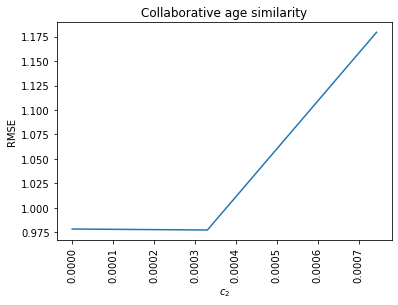

In [189]:
results_collab_age_c2 = {'c2':[0, 1/3025., 2.25/3025.],
                         'RMSE':[0.9784298638900913, 0.9774542378193612, 1.179317334846991]}
plt.plot(results_collab_age_c2['c2'], results_collab_age_c2['RMSE'])
plt.xticks(rotation = 90)
plt.ylabel('RMSE')
plt.xlabel('$c_2$')
plt.title('Collaborative age similarity');

In [ ]:
#Idea: 1/sqrt()
1/np.sqrt(0.6)

### Zip code similarity

In [30]:
movielens_train.head()

,user_id,movie_id,rating,timestamp,gender,age,occupation,zip,title,genres
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,M,25,12,32793,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,M,50,1,95350,One Flew Over the Cuckoo's Nest (1975),Drama
5,18,1193,4,978156168,F,18,3,95825,One Flew Over the Cuckoo's Nest (1975),Drama
6,19,1193,5,982730936,M,1,10,48073,One Flew Over the Cuckoo's Nest (1975),Drama


In [33]:
zip_min = int(movielens_train.zip.min())
zip_max = int(movielens_train.zip.max())
print("Min zip =",zip_min)
print("Max zip =",zip_max)
zip_amplitude = zip_max - zip_min
print("zip_amplitude =",zip_amplitude)

Min zip = 231
Max zip = 99945
zip_amplitude = 99714


In [80]:
def sim_p1_zip(n1, n2):
    # linear function of age difference
    # zip_amplitude = 99714
    x = abs(n1 - n2)
    return 1 - x / zip_amplitude

In [82]:
def collab_zip_p1_sim(user_id, movie_id):
    """ Collaborative filtering using a custom zip sim(u,u'). """
    # Ratings weighted by age similarity.
    user_condition = movielens_train.user_id != user_id
    movie_condition = movielens_train.movie_id == movie_id
    ratings_by_others = movielens_train.loc[user_condition & movie_condition]
    if ratings_by_others.empty:
        return 4.0
    ratings_by_others.set_index('user_id', inplace=True)
    their_ids = ratings_by_others.index
    their_ratings = ratings_by_others.rating
    their_zips = ratings_by_others['zip']
    user_zip = user_info.loc[user_id, 'zip']
    sims = their_zips.apply(lambda zip_str: sim_p1_zip(int(zip_str[:5]), int(user_zip[:5]))) #, axis=0
    ratings_sims = pd.DataFrame({'sim': sims, 'rating': their_ratings})
    #ratings_sims = ratings_sims[ratings_sims.sim > 0]
    if ratings_sims.empty:
        return their_ratings.mean()
    else:
        return np.average(ratings_sims.rating, weights=ratings_sims.sim)
    
print('RMSE for collab_age_sim: %s' % evaluate(collab_zip_p1_sim))

RMSE for collab_age_sim: 0.9803610117625101


In [83]:
results = {'model':['const_1','const_2','const_3','const_4','const_5',\
                    'content_mean','collab_mean','content_median','collab_median','collab_gender',\
                    'collab_age_sim', 'collab_age3_sim', 'collab_zip_p1_sim'],
          'RMSE':[2.8136200070222306, 1.9370395076943017, 1.2600740314844154, 1.1930846890620097,1.8053020760324288,\
                 1.0358078857231683,0.9799205786940289,1.088656793273783,1.0286959097771768,0.9798246061386189,\
                 0.9772907088995219, 0.9774542378193612, 0.9803610117625101]}

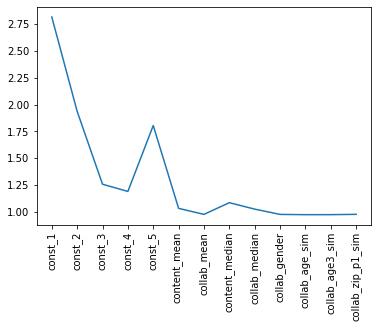

In [84]:
plt.plot(results['model'], results['RMSE'])
plt.xticks(rotation = 90);

In [26]:
# Best model so far
def collab_age_sim(user_id, movie_id):
    """ Collaborative filtering using a custom age sim(u,u'). """
    # Ratings weighted by age similarity.
    user_condition = movielens_train.user_id != user_id
    movie_condition = movielens_train.movie_id == movie_id
    ratings_by_others = movielens_train.loc[user_condition & movie_condition]
    if ratings_by_others.empty:
        return 4.0
    ratings_by_others.set_index('user_id', inplace=True)
    their_ids = ratings_by_others.index
    their_ratings = ratings_by_others.rating
    their_ages = ratings_by_others['age']
    #user_age = movielens_train.loc[movielens_train['user_id'] == user_id, 'age']
    user_age = user_info.loc[user_id, 'age']
    sims = their_ages.apply(lambda age: sim_age(age, user_age)) #, axis=0
    ratings_sims = pd.DataFrame({'sim': sims, 'rating': their_ratings})
    ratings_sims = ratings_sims[ratings_sims.sim > 0]
    if ratings_sims.empty:
        return their_ratings.mean()
    else:
        return np.average(ratings_sims.rating, weights=ratings_sims.sim)
    
#print('RMSE for collab_age_sim: %s' % evaluate(collab_age_sim))
RMSE_min = 0.9772907088995219

In [ ]:
def collab_age_sim(user_id, movie_id):
    """ Collaborative filtering using a custom age sim(u,u'). """
    # Ratings weighted by age similarity.
    user_condition = movielens_train.user_id != user_id
    movie_condition = movielens_train.movie_id == movie_id
    ratings_by_others = movielens_train.loc[user_condition & movie_condition]
    if ratings_by_others.empty:
        return 4.0
    ratings_by_others.set_index('user_id', inplace=True)
    their_ids = ratings_by_others.index
    their_ratings = ratings_by_others.rating
    their_ages = ratings_by_others['age']
    user_age = user_info.loc[user_id, 'age']
    sims = their_ages.apply(lambda age: sim_age(age, user_age)) #, axis=0
    ratings_sims = pd.DataFrame({'sim': sims, 'rating': their_ratings})
    ratings_sims = ratings_sims[ratings_sims.sim > 0]
    if ratings_sims.empty:
        return their_ratings.mean()
    else:
        return np.average(ratings_sims.rating, weights=ratings_sims.sim)

print('RMSE for collab_age_sim: %s' % evaluate(collab_age_sim))